# Final Project Report - DAT650, Blockchain Technology - University of Stavanger - Fall, 2021

In this project, we invastigate the effects each of the three main constraints on selfish mining strategy and its total profit relativ to honest mining, these constraints are the number of selfish miners vs. the number of honest miners, the mining power, and the network power.

To better isolate and observe the effect of mining and network power, we choose to:
1. set the network power to be random by picking a random blockchain when forks appear as a result of selfish mining when simulating/varying the mining power
2. set the mining power to be equal for each miner in the simulation when simulating/varying the network power.

The table below explains the multiple simulations that is carried out in this notebook.

| Number of Simulation | Simulation Goal | Number of selfish miners | Number of honest miners | Mining power | Network Power |
| --- | --- | --- | --- | --- | --- |
| 1 | Determine the effect of an increasing mining power of just one selfish miner | 1 selfish | 99 honest | Increasing the mining power of the one selfish miner and decreasing the mining power of the honest miner(s) throughout the simulations | Random for all miners |
| 2 | Determine the effect of an increasing number of selfish miners where all individual honest and selfish miners have equal mining power | increasing the number of selfish miners by i and therefore their total selfish mining power at each step throughout the simulation | decreasing the number of honest miners by i and therefore their total honest mining power at each step throughout the simulation | Equal between all miners | Random for all miners |
| 3 | Determine the effect of an increasing network power of just one selfish miner  | 1 selfish | 99 honest | Equal between all miners | Increasing the network power of the selfish miner and decreasing the network power of the honest miners throughout the simulations |
| 4 | Determine the effect of an increasing number of selfish miners where all individual honest and selfish miners have equal network and mining power | increasing the number of selfish miners and therefore their total selfish network power at each step throughout the simulation | decreasing the number of honest miners and therefore their total honest network power at each step throughout the simulation | Equal between all miners | Equal between all miners |

In [1]:
import random
import hashlib as hasher

def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def numberOfInitZeros(hashStr):
    count = 0
    for i in range (0 , len(hashStr)):
        if hashStr[i] == '1':
            break
        count += 1
    return count

class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Miner(0 , "0")
            self.height = 0
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []

    def hash_block(self):
        return hashbits(self.data+ self.creator.name + self.previous_hash + str(self.nonce))

class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0

    def longestChain(self):
        max = self.chain[0].height
        for block in self.chain:
            if block.height > max:
                max = block.height
        maxes = [block for block in self.chain if block.height == max]
        r = random.choices(maxes, k=1)
        return r[0]
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1

    def checkMiner(self, miner):
        last = self.longestChain()
        count = 0
        while last!=None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count
            
class Miner:
    def __init__(self, miningPower, name, blockchain=None):
        self.miningPower = miningPower
        self.nonce = random.randint(0,100000)
        self.name = name
        self.blockchain = blockchain
        if self.blockchain != None:
            self.lastBlock = blockchain.longestChain()
  
    def UpdateLast(self):
        latest = self.blockchain.longestChain()
        if latest.height > self.lastBlock.height:
            self.lastBlock = latest
        
    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                self.blockchain.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

class SelfishMiner(Miner):
    def __init__(self, miningPower, name, blockchain=None):
        super().__init__(miningPower, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False

    def UpdateLast(self):
        #add this function
        latest = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks)> 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True

    def PoWSolver(self):
        #add this function - selfish PoW
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

We start by defining a method for running the core of the simulation

In [2]:
"""
A method that runs the simulation of mining

Inputs: 
- The blockchain instance (bc),
- An array of honest miners (honest_miners),
- An array of selfish miners (selfish_miners)

Outputs:
- The percentage of blocks mined by honest miners (honest_profit)
- The percentage of blocks mined by selfish miners (selfish_profit)
"""
def simulate_selfish_mining(bc, honest_miners, selfish_miners):
    run_to = 101
    while bc.size < run_to:
        for s in selfish_miners:
            s.PoWSolver()

        for m in honest_miners:
            m.PoWSolver()

        for s in selfish_miners:
            s.UpdateLast()

        for m in honest_miners:
            m.UpdateLast()
    
    selfish_profit = 0
    bc_height = bc.longestChain().height
    for selfish_miner in selfish_miners:
        percentage_of_miner_blocks = bc.checkMiner(selfish_miner) / bc_height
        selfish_profit += percentage_of_miner_blocks
    
    honest_profit = 0
    for honest_miner in honest_miners:
        percentage_of_miner_blocks = bc.checkMiner(honest_miner) / bc_height
        honest_profit += percentage_of_miner_blocks
        
    return selfish_profit, honest_profit

### Mining Power Analysis and Simulation
## Simulation nr. 1: 
In this simulation, we aim to determine the effect of an increasing mining power of just one selfish miner, the simulation has the following setup:

A) Total available mining power of 100

B) starting the total selfish mining power at 0, and

C) starting the total honest mining power at 100

D) Total number of miners is 100

E) Mining power will vary from one miner to another, beacuse we are
    1. Increasing the mining power of the 1 selfish miner from 0 to 99 with selfish_power += 1
    2. decreasing the mining power of the 99 honest miners from 100 to 1 with honest_power -= 1
   
F) Network power is equally random to all miners, so when forks appears between multiple longest blockchains, a random blockchain is picked up.

In [3]:
"""
This method makes miners of a given type (selfish/honest), and
divides the mining power share equally on the generated miners

example:
> if we make the following call:
> make_miners(type_of_minors="selfish", num_of_miners=40, total_mining_power=80, blockchain)
> we should get an array of selfish miners, where each miner has 80/40 = 2 mining power

However if we call the same method with
> make_miners(type_of_minors="selfish", num_of_miners=60, total_mining_power=20, blockchain)
> due to the use of round method on calculating the individual mining power, 
    only 20 miners will get a power of 1 and the rest will have no mining power, 
    i.e. mining power of 0. 
"""

def make_miners(type_of_minors, num_of_miners, total_mining_power, blockchain):
    miners = []
    remaining_mining_power = total_mining_power
    
    while len(miners) < num_of_miners:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, f"Selfish miner nr. {len(miners)+1}", blockchain)
        
        miners.append(miner)
        remaining_mining_power -= mining_power
        
    return miners

"""
The code below runs simulation nr. 1, se table at the head of this notebook for summary details
"""
output = True # Set this to False to disable update messages from simulations
selfish_profits = []
honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

for selfish_power in sim_range_selfish:
    num_of_selfish_miners = 1
    num_of_honest_miners = 99
    total_mining_power = 100
    honest_power_share = round((100-selfish_power)/100, 2) 
    selfish_power_share = round(selfish_power/100, 2) 
    
    honest_mining_power = round(total_mining_power * honest_power_share)
    selfish_mining_power = round(total_mining_power * selfish_power_share)
    
    bc = Blockchain("0" , 7)

    honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power, bc)
    
    selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power, bc)
        
    if output:
        print(f"Running simulation of mining power with:")
        print(f"-> {len(honest_miners)} honest minors having {round(honest_power_share*100)}% of total mining power")
        print(f"-> {len(selfish_miners)} selfish minors having {round(selfish_power_share*100)}% of total mining power")
        print("...")
    
    selfish_profit, honest_profit = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    selfish_profits.append(selfish_profit)
    honest_profits.append(honest_profit)
    
    if output:
        print(f"Honest profit: {honest_profit}")
        print(f"Selfish profit: {selfish_profit}")
        print(f"Total profit: {selfish_profit+honest_profit}")
        print()

Running simulation of mining power with:
-> 99 honest minors having 100% of total mining power
-> 1 selfish minors having 0% of total mining power
...
Honest profit: 1.0158730158730154
Selfish profit: 0.0
Total profit: 1.0158730158730154

Running simulation of mining power with:
-> 99 honest minors having 99% of total mining power
-> 1 selfish minors having 1% of total mining power
...
Honest profit: 0.9701492537313439
Selfish profit: 0.029850746268656716
Total profit: 1.0000000000000007

Running simulation of mining power with:
-> 99 honest minors having 98% of total mining power
-> 1 selfish minors having 2% of total mining power
...
Honest profit: 0.9841269841269833
Selfish profit: 0.015873015873015872
Total profit: 0.9999999999999991

Running simulation of mining power with:
-> 99 honest minors having 97% of total mining power
-> 1 selfish minors having 3% of total mining power
...
Honest profit: 0.9726027397260275
Selfish profit: 0.0273972602739726
Total profit: 1.0

Running simul

Honest profit: 0.6034482758620687
Selfish profit: 0.3620689655172414
Total profit: 0.96551724137931

Running simulation of mining power with:
-> 99 honest minors having 66% of total mining power
-> 1 selfish minors having 34% of total mining power
...
Honest profit: 0.6153846153846153
Selfish profit: 0.40384615384615385
Total profit: 1.0192307692307692

Running simulation of mining power with:
-> 99 honest minors having 65% of total mining power
-> 1 selfish minors having 35% of total mining power
...
Honest profit: 0.6129032258064512
Selfish profit: 0.3870967741935484
Total profit: 0.9999999999999996

Running simulation of mining power with:
-> 99 honest minors having 64% of total mining power
-> 1 selfish minors having 36% of total mining power
...
Honest profit: 0.36666666666666664
Selfish profit: 0.6333333333333333
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 63% of total mining power
-> 1 selfish minors having 37% of total mining power
...

Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 32% of total mining power
-> 1 selfish minors having 68% of total mining power
...
Honest profit: 0.98
Selfish profit: 0.02
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 31% of total mining power
-> 1 selfish minors having 69% of total mining power
...
Honest profit: 0.9175257731958762
Selfish profit: 0.08247422680412371
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 30% of total mining power
-> 1 selfish minors having 70% of total mining power
...
Honest profit: 0.9595959595959596
Selfish profit: 0.04040404040404041
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 29% of total mining power
-> 1 selfish minors having 71% of total mining power
...
Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-

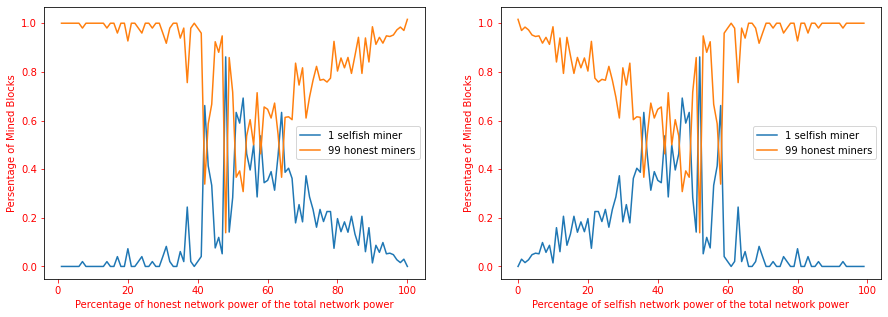

In [4]:
"""
Drawing the results of the previous simulation nr. 1

--- A reminder of Simulation Details ---
In this simulation, we aim to determine the effect of an increasing mining power of just 
one selfish miner, the simulation has the following setup:

A) Total available mining power of 100

B) starting the total selfish mining power at 0, and

C) starting the total honest mining power at 100

D) Total number of miners is 100

E) Mining power will vary from one miner to another, beacuse we are
    1. Increasing the mining power of the 1 selfish miner from 0 to 99 with selfish_power += 1
    2. decreasing the mining power of the 99 honest miners from 100 to 1 with honest_power -= 1
   
F) Network power is equally random to all miners, so when forks appears between 
    multiple longest blockchains, a random blockchain is picked up.
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(honest_power, selfish_profits, label = "1 selfish miner")
axs[0].plot(honest_power, honest_profits, label = "99 honest miners")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_xlabel('Percentage of honest network power of the total network power').set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[0].legend()

axs[1].plot(selfish_power, selfish_profits, label = "1 selfish miner")
axs[1].plot(selfish_power, honest_profits, label = "99 honest miners")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_xlabel('Percentage of selfish network power of the total network power').set_color('red')
axs[1].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[1].legend()

### Mining Power Analysis and Simulation
## Simulation nr. 2: 

In this simulation we aim to determine the effect of an increasing number of selfish miners where all individual honest and selfish miners have equal mining power, but where the number of selfish miners increases with i=1 at a time and the number honest miners decreases with i=1 at the same time. This simulation has the following setup:

A) Total available mining power of 100

B) starting the total selfish mining power at 0

C) starting the total honest mining power at 100

D) Total number of miners is 100

E) Each miner will have the same mining power as other miners, beacuse we are
1. Increasing the selfish mining power from 0 to 99 with selfish_mining_power += 1, and 
    at the same time increasing the number of selfish miners from 0 to 99 with 
    num_selfish_miners += 1
2. decreasing the honest mining power from 100 to 1 with honest_mining_power += 1, and 
    at the same time decreasing the number of honest miners from 100 to 1 with 
    num_honest_miners += 1
    
F) Network power is equally random to all miners, so when forks appears between multiple longest blockchains, a random blockchain is picked up.

In [5]:
"""
This method makes miners of a given type (selfish/honest), and
divides the mining power share equally on the generated miners

example:
> if we make the following call:
> make_miners(type_of_minors="selfish", num_of_miners=40, total_mining_power=80)
> we should get an array of selfish miners, where each miner has 80/40 = 2 mining power

However if we call the same method with
> make_miners(type_of_minors="honest", num_of_miners=60, total_mining_power=20)
> due to the use of round method on calculating the individual mining power, 
    only 20 miners will get a power of 1 and the rest will have no mining power, 
    i.e. mining power of 0. 
"""
def make_miners(type_of_minors, num_of_miners, total_mining_power):
    miners = []
    remaining_mining_power = total_mining_power
    
    while remaining_mining_power > 0:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, f"Honest miner nr. {len(miners)+1}", bc)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, f"Selfish miner nr. {len(miners)+1}", bc)
        
        miners.append(miner)
        remaining_mining_power -= mining_power
        
    return miners

"""
The code below runs simulation nr. 2, se table at the head of this notebook for summary details
"""
output = True # Set this to False to disable update messages from simulations
selfish_profits = []
honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

for i in sim_range_selfish:
    num_of_selfish_miners = i
    num_of_honest_miners = 100-i
    total_mining_power = 100
    honest_power_share = round(num_of_honest_miners/100, 2)
    selfish_power_share = round(num_of_selfish_miners/100, 2)
    
    honest_mining_power = round(total_mining_power * honest_power_share)
    selfish_mining_power = round(total_mining_power * selfish_power_share)

    bc = Blockchain("0" , 7)
    
    honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power)
    
    selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power)
        
    if output:
        print(f"Running simulation of mining power with:")
        print(f"-> {len(honest_miners)} honest minors having {round(honest_power_share*100)}% of total mining power")
        print(f"-> {len(selfish_miners)} selfish minors having {round(selfish_power_share*100)}% of total mining power")
        print("...")
        
    selfish_profit, honest_profit = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    selfish_profits.append(selfish_profit)
    honest_profits.append(honest_profit)
    
    if output:
        print(f"Honest profit: {honest_profit}")
        print(f"Selfish profit: {selfish_profit}")
        print(f"Total profit: {selfish_profit+honest_profit}")
        print()
    

Running simulation of mining power with:
-> 100 honest minors having 100% of total mining power
-> 0 selfish minors having 0% of total mining power
...
Honest profit: 0.999999999999999
Selfish profit: 0
Total profit: 0.999999999999999

Running simulation of mining power with:
-> 99 honest minors having 99% of total mining power
-> 1 selfish minors having 1% of total mining power
...
Honest profit: 1.0000000000000007
Selfish profit: 0.0
Total profit: 1.0000000000000007

Running simulation of mining power with:
-> 98 honest minors having 98% of total mining power
-> 2 selfish minors having 2% of total mining power
...
Honest profit: 0.9558823529411756
Selfish profit: 0.044117647058823525
Total profit: 0.9999999999999991

Running simulation of mining power with:
-> 97 honest minors having 97% of total mining power
-> 3 selfish minors having 3% of total mining power
...
Honest profit: 1.0000000000000009
Selfish profit: 0.016666666666666666
Total profit: 1.0166666666666675

Running simulati

Honest profit: 0.8730158730158728
Selfish profit: 0.14285714285714285
Total profit: 1.0158730158730156

Running simulation of mining power with:
-> 67 honest minors having 67% of total mining power
-> 33 selfish minors having 33% of total mining power
...
Honest profit: 0.7719298245614036
Selfish profit: 0.22807017543859648
Total profit: 1.0

Running simulation of mining power with:
-> 66 honest minors having 66% of total mining power
-> 34 selfish minors having 34% of total mining power
...
Honest profit: 0.8461538461538464
Selfish profit: 0.11538461538461539
Total profit: 0.9615384615384618

Running simulation of mining power with:
-> 65 honest minors having 65% of total mining power
-> 35 selfish minors having 35% of total mining power
...
Honest profit: 0.8070175438596492
Selfish profit: 0.17543859649122806
Total profit: 0.9824561403508772

Running simulation of mining power with:
-> 64 honest minors having 64% of total mining power
-> 36 selfish minors having 36% of total mining p

Honest profit: 0.5
Selfish profit: 0.5294117647058824
Total profit: 1.0294117647058822

Running simulation of mining power with:
-> 34 honest minors having 34% of total mining power
-> 66 selfish minors having 66% of total mining power
...
Honest profit: 0.4193548387096774
Selfish profit: 0.5806451612903225
Total profit: 0.9999999999999999

Running simulation of mining power with:
-> 33 honest minors having 33% of total mining power
-> 67 selfish minors having 67% of total mining power
...
Honest profit: 0.48484848484848475
Selfish profit: 0.5454545454545453
Total profit: 1.03030303030303

Running simulation of mining power with:
-> 32 honest minors having 32% of total mining power
-> 68 selfish minors having 68% of total mining power
...
Honest profit: 0.5806451612903224
Selfish profit: 0.4516129032258063
Total profit: 1.0322580645161286

Running simulation of mining power with:
-> 31 honest minors having 31% of total mining power
-> 69 selfish minors having 69% of total mining power


Honest profit: 0.0
Selfish profit: 1.0
Total profit: 1.0



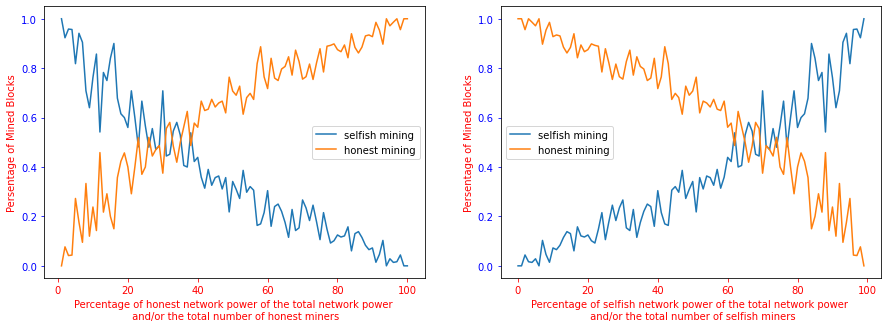

In [6]:
"""
Drawing the results of the previous simulation nr. 2

--- A reminder of Simulation Details ---
In this simulation we aim to determine the effect of an increasing number of selfish miners where all individual honest and selfish miners have equal mining power, but where the number of selfish miners increases with i=1 at a time and the number honest miners decreases with i=1 at the same time. This simulation has the following setup:

A) Total available mining power of 100

B) starting the total selfish mining power at 0

C) starting the total honest mining power at 100

D) Total number of miners is 100

E) Each miner will have the same mining power as other miners, beacuse we are

    Increasing the selfish mining power from 0 to 99 with selfish_mining_power += 1, and at the same time increasing the number of selfish miners from 0 to 99 with num_selfish_miners += 1
    decreasing the honest mining power from 100 to 1 with honest_mining_power += 1, and at the same time decreasing the number of honest miners from 100 to 1 with num_honest_miners += 1

F) Network power is equally random to all miners, so when forks appears between multiple longest blockchains, a random blockchain is picked up.
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(honest_power, selfish_profits, label = "selfish mining")
axs[0].plot(honest_power, honest_profits, label = "honest mining")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='blue')
axs[0].set_xlabel('Percentage of honest network power of the total network power \n and/or the total number of honest miners').set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[0].legend()

axs[1].plot(selfish_power, selfish_profits, label = "selfish mining")
axs[1].plot(selfish_power, honest_profits, label = "honest mining")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='blue')
axs[1].set_xlabel('Percentage of selfish network power of the total network power \n and/or the total number of selfish miners').set_color('red')
axs[1].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[1].legend()

### Network Power Analysis and Simulation

#### The following redesign steps was added to the previous core classes to implement network power

A) Redesigning the longestChain() method in the Blockchain class to simulate network power.

B) Adding an additional attribute to define the network power of a certain miner in the Miner and SelfishMiner classes.

C) Editing the Block class to implement the changes in B)above.

In [7]:
class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            if creator != None:
                self.creator = Miner(0 , creator.networkingPower, creator.miner_type ,"0")
            else:
                self.creator = Miner(0 , None, None, "0")
            self.height = 0
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []

    def hash_block(self):
        return hashbits(self.data+ self.creator.name + self.previous_hash + str(self.nonce))


class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0

    def longestChain(self):
        max = self.chain[0].height
        for block in self.chain:
            if block.height > max:
                max = block.height
        maxes = [block for block in self.chain if block.height == max]
        
        new_maxes = []
        if len(maxes) > 1:
            chances = list(range(1, 101, 1))
            choice = random.choice(chances)
            for block in maxes:
                creator_networking_power = block.creator.networkingPower
                if choice <= creator_networking_power:
                    new_maxes.append(block)
        else:
            new_maxes = maxes
            
        if len(new_maxes) == 0:
            new_maxes = maxes
        return new_maxes[0]
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1

    def checkMiner(self, miner):
        last = self.longestChain()
        count = 0
        while last!=None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count
            
class Miner:
    def __init__(self, miningPower, networkingPower, miner_type, name, blockchain=None):
        self.miningPower = miningPower
        self.networkingPower = networkingPower
        self.miner_type = miner_type
        self.nonce = random.randint(0,100000)
        self.name = name
        self.blockchain = blockchain
        if self.blockchain != None:
            self.lastBlock = blockchain.longestChain()
  
    def UpdateLast(self):
        latest = self.blockchain.longestChain()
        if latest.height > self.lastBlock.height:
            self.lastBlock = latest
        
    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                self.blockchain.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

class SelfishMiner(Miner):
    def __init__(self, miningPower, networkingPower, miner_type, name, blockchain=None):
        super().__init__(miningPower, networkingPower, miner_type, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False

    def UpdateLast(self):
        #add this function
        latest = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks)> 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True

    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

### Network Power Analysis and Simulation
## Simulation nr. 3: 
In this simulation, we aim to determine the effect of an increasing network power of just one selfish miner, the simulation has the following setup:

Network Power will be used in the longestChain() method to increase the chances of a certain block creator to have his block and its previous blockchain replicated faster than other the blocks from other miners with low network power.

Also note that the block is still chossen randomly in the longestChain() method. However, now we are increasing the chances by checking the network power of a miner who created that block and if it is found out to be smaller than a randomly generated number between 0 to 100 than his block gets replicated and if not, his block does not get replicated across the network in the simulation. 

A) Total available network power of 100

B) starting the total selfish network power at 0, and

C) starting the total honest network power at 100

D) Total number of miners is 100, always having 99 honest miners and 1 selfish miner

E) Network power will vary from one miner to another, beacuse we are 
1. Increasing the network power of the 1 selfish miner from 0 to 99 with selfish_network_power += 1, and 
2. decreasing the network power of the 99 honest miners from 100 to 1 with honest_network_power -= 1.

F) Total mining power is 100 and it is divided equally among all miners, so each one of the 100 miners will have a mining power of 1 no matter if he is a selfish or honest miner.

In [8]:
import random

"""
This method makes miners of a given type (selfish/honest), and
divides the mining power share equally on the generated miners

example:
> if we make the following call:
> make_miners(type_of_minors="selfish", total_network_power=40, num_of_miners=40, total_mining_power=80)
> we should get an array of selfish miners, where each miner has 80/40 = 2 mining power
> and randmomly assign network power among these selfish miners out of 40 avialable in total

However if we call the same method with
> make_miners(type_of_minors="honest", num_of_miners=60, total_mining_power=20)
> due to the use of round method on calculating the individual mining power, 
    only 20 miners will get a power of 1 and the rest will have no mining power, 
    i.e. mining power of 0. 
> and randmomly assigns network power among these honest miners out of 40 avialable in total
"""
def make_miners(type_of_minors, total_network_power, num_of_miners, total_mining_power, blockchain):
    miners = []
    remaining_mining_power = total_mining_power
    
    remaining_network_power = total_network_power
    
    while remaining_mining_power > 0:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
            network_power = remaining_network_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
            
            if remaining_network_power != 0:
                possible_network_power = list(range(1, remaining_network_power+1, 1))
                network_power = random.choice(possible_network_power)
                remaining_network_power -= network_power
            else:
                network_power = 0
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, network_power, "Honest", f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, network_power, "Selfish", f"Selfish miner nr. {len(miners)+1}", blockchain)
        
        miners.append(miner)
        remaining_mining_power -= mining_power
        
    return miners

"""
The code below runs simulation nr. 3, se table at the head of this notebook for summary details
"""
output = True
selfish_profits = []
honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

for i in sim_range_selfish:
    num_of_selfish_miners = 1
    num_of_honest_miners = 99
    
    total_mining_power = 100
    honest_power_share = round(num_of_honest_miners/100, 2)
    selfish_power_share = round(num_of_selfish_miners/100, 2)
    honest_mining_power = round(total_mining_power * honest_power_share)
    selfish_mining_power = round(total_mining_power * selfish_power_share)
    
    selfish_networking_power = i
    honest_networking_power = 100-i
    
    bc = Blockchain("0" , 7)
    
    honest_miners = make_miners("honest", honest_networking_power, num_of_honest_miners, honest_mining_power, bc)
    
    selfish_miners = make_miners("selfish", selfish_networking_power, num_of_selfish_miners, selfish_mining_power, bc)
        
    if output:
        print(f"Running simulation of networking power with:")
        print(f"-> {len(honest_miners)} honest minors having {honest_networking_power}% of total networking power")
        print(f"-> {len(selfish_miners)} selfish minors having {selfish_networking_power}% of total networking power")
        print("...")
        
    selfish_profit, honest_profit = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    selfish_profits.append(selfish_profit)
    honest_profits.append(honest_profit)
    
    if output:
        print(f"Honest profit: {honest_profit}")
        print(f"Selfish profit: {selfish_profit}")
        print(f"Total profit: {selfish_profit+honest_profit}")
        print()
    


Running simulation of networking power with:
-> 99 honest minors having 100% of total networking power
-> 1 selfish minors having 0% of total networking power
...
Honest profit: 1.000000000000001
Selfish profit: 0.0
Total profit: 1.000000000000001

Running simulation of networking power with:
-> 99 honest minors having 99% of total networking power
-> 1 selfish minors having 1% of total networking power
...
Honest profit: 0.9999999999999992
Selfish profit: 0.0
Total profit: 0.9999999999999992

Running simulation of networking power with:
-> 99 honest minors having 98% of total networking power
-> 1 selfish minors having 2% of total networking power
...
Honest profit: 1.0000000000000002
Selfish profit: 0.0
Total profit: 1.0000000000000002

Running simulation of networking power with:
-> 99 honest minors having 97% of total networking power
-> 1 selfish minors having 3% of total networking power
...
Honest profit: 1.0000000000000004
Selfish profit: 0.0
Total profit: 1.0000000000000004

R

Honest profit: 0.9852941176470577
Selfish profit: 0.014705882352941176
Total profit: 0.9999999999999988

Running simulation of networking power with:
-> 99 honest minors having 66% of total networking power
-> 1 selfish minors having 34% of total networking power
...
Honest profit: 0.9999999999999993
Selfish profit: 0.0
Total profit: 0.9999999999999993

Running simulation of networking power with:
-> 99 honest minors having 65% of total networking power
-> 1 selfish minors having 35% of total networking power
...
Honest profit: 1.0000000000000004
Selfish profit: 0.0
Total profit: 1.0000000000000004

Running simulation of networking power with:
-> 99 honest minors having 64% of total networking power
-> 1 selfish minors having 36% of total networking power
...
Honest profit: 0.999999999999999
Selfish profit: 0.0
Total profit: 0.999999999999999

Running simulation of networking power with:
-> 99 honest minors having 63% of total networking power
-> 1 selfish minors having 37% of total ne

Honest profit: 0.9861111111111103
Selfish profit: 0.013888888888888888
Total profit: 0.9999999999999991

Running simulation of networking power with:
-> 99 honest minors having 33% of total networking power
-> 1 selfish minors having 67% of total networking power
...
Honest profit: 0.985507246376811
Selfish profit: 0.014492753623188406
Total profit: 0.9999999999999993

Running simulation of networking power with:
-> 99 honest minors having 32% of total networking power
-> 1 selfish minors having 68% of total networking power
...
Honest profit: 0.9855072463768111
Selfish profit: 0.014492753623188406
Total profit: 0.9999999999999994

Running simulation of networking power with:
-> 99 honest minors having 31% of total networking power
-> 1 selfish minors having 69% of total networking power
...
Honest profit: 0.9999999999999993
Selfish profit: 0.0
Total profit: 0.9999999999999993

Running simulation of networking power with:
-> 99 honest minors having 30% of total networking power
-> 1 se

Honest profit: 0.9999999999999989
Selfish profit: 0.0
Total profit: 0.9999999999999989

Running simulation of networking power with:
-> 99 honest minors having 1% of total networking power
-> 1 selfish minors having 99% of total networking power
...
Honest profit: 1.0000000000000004
Selfish profit: 0.0
Total profit: 1.0000000000000004



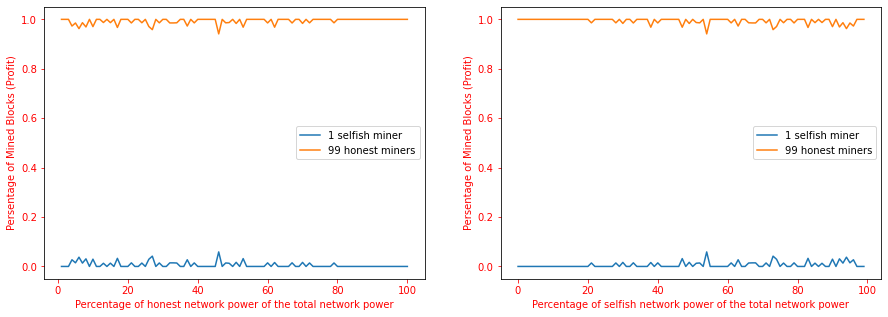

In [9]:
"""
Drawing the results of the previous simulation nr. 3

--- A reminder of Simulation Details ---
In this simulation, we aim to determine the effect of an increasing network power of just one selfish miner, the simulation has the following setup:

Network Power will be used in the longestChain() method to increase the chances of a certain block creator to have his block and its previous blockchain replicated faster than other the blocks from other miners with low network power.

Also note that the block is still chossen randomly in the longestChain() method. However, now we are increasing the chances by checking the network power of a miner who created that block and if it is found out to be smaller than a randomly generated number between 0 to 100 than his block gets replicated and if not, his block does not get replicated across the network in the simulation.

A) Total available network power of 100

B) starting the total selfish network power at 0, and

C) starting the total honest network power at 100

D) Total number of miners is 100, always having 99 honest miners and 1 selfish miner

E) Network power will vary from one miner to another, beacuse we are

    Increasing the network power of the 1 selfish miner from 0 to 99 with selfish_network_power += 1, and
    decreasing the network power of the 99 honest miners from 100 to 1 with honest_network_power -= 1.

F) Total mining power is 100 and it is divided equally among all miners, so each one of the 100 miners will have a mining power of 1 no matter if he is a selfish or honest miner.
"""
import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(honest_power, selfish_profits, label = "1 selfish miner")
axs[0].plot(honest_power, honest_profits, label = "99 honest miners")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_xlabel('Percentage of honest network power of the total network power').set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks (Profit)').set_color('red')
axs[0].legend()

axs[1].plot(selfish_power, selfish_profits, label = "1 selfish miner")
axs[1].plot(selfish_power, honest_profits, label = "99 honest miners")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_xlabel('Percentage of selfish network power of the total network power').set_color('red')
axs[1].set_ylabel('Persentage of Mined Blocks (Profit)').set_color('red')
axs[1].legend()

### Network Power Analysis and Simulation
## Simulation nr. 4: 
In this simulation we aim to determine the effect of an increasing number of selfish miners where all individual honest and selfish miners have equal network and mining power. This simulation has the following setup:

A) Total available mining power of 100

B) starting the total selfish network power at 0

C) starting the total honest network power at 100

D) Total number of miners is 100

E) Each miner will have the same network power as other miners, beacuse we are
1. Increasing the selfish network power from 0 to 99 with selfish_network_power += 1, and at the same time increasing the number of selfish miners from 0 to 99 with num_selfish_miners += 1
2. decreasing the honest network power from 100 to 1 with honest_network_power += 1, and at the same time decreasing the number of honest miners from 100 to 1 with num_honest_miners += 1

F) Mining power is equally divided among to all miners, each miner having a mining power of 1.

In [10]:
"""
The code below runs simulation nr. 3, se table at the head of this notebook for summary details
"""
output = True
selfish_profits = []
honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

print("Simulating varying network power between miners with")
print("-> equal mining power for each miner")
print("-> and varying the number of honest and selfish miners at each simulation")
print("")

for i in sim_range_selfish:
    num_of_selfish_miners = i
    num_of_honest_miners = 100-i
    
    total_mining_power = 100
    honest_mining_power_share = round(num_of_honest_miners/total_mining_power, 2)
    selfish_mining_power_share = round(num_of_selfish_miners/total_mining_power, 2)
    honest_mining_power = round(total_mining_power * honest_mining_power_share)
    selfish_mining_power = round(total_mining_power * selfish_mining_power_share)
    
    total_network_power = 100
    honest_network_power_share = round(num_of_honest_miners/total_network_power, 2)
    selfish_network_power_share = round(num_of_selfish_miners/total_network_power, 2)
    honest_network_power = round(total_network_power * honest_network_power_share)
    selfish_network_power = round(total_network_power * selfish_network_power_share)

    bc = Blockchain("0" , 7)
    
    honest_miners = make_miners("honest", honest_network_power, num_of_honest_miners, honest_mining_power, bc)
    
    selfish_miners = make_miners("selfish", selfish_network_power, num_of_selfish_miners, selfish_mining_power, bc)
        
    if output:
        print(f"Running simulation with:")
        print(f"-> {len(honest_miners)} honest minors having {honest_network_power}% of total networking power and {honest_mining_power}% of total mining power")
        print(f"-> {len(selfish_miners)} selfish minors having {selfish_network_power}% of total networking power and {selfish_mining_power}% of total mining power")
        print("...")
        
    selfish_profit, honest_profit = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    selfish_profits.append(selfish_profit)
    honest_profits.append(honest_profit)
    
    if output:
        print(f"Honest profit: {honest_profit}")
        print(f"Selfish profit: {selfish_profit}")
        print(f"Total profit: {round(selfish_profit+honest_profit)}")
        print()
    

Simulating varying network power between miners with
-> equal mining power for each miner
-> and varying the number of honest and selfish miners at each simulation

Running simulation with:
-> 100 honest minors having 100% of total networking power and 100% of total mining power
-> 0 selfish minors having 0% of total networking power and 0% of total mining power
...
Honest profit: 0.999999999999999
Selfish profit: 0
Total profit: 1

Running simulation with:
-> 99 honest minors having 99% of total networking power and 99% of total mining power
-> 1 selfish minors having 1% of total networking power and 1% of total mining power
...
Honest profit: 1.0000000000000004
Selfish profit: 0.0
Total profit: 1

Running simulation with:
-> 98 honest minors having 98% of total networking power and 98% of total mining power
-> 2 selfish minors having 2% of total networking power and 2% of total mining power
...
Honest profit: 0.9999999999999996
Selfish profit: 0.0
Total profit: 1

Running simulation 

Honest profit: 0.9464285714285718
Selfish profit: 0.05357142857142857
Total profit: 1

Running simulation with:
-> 70 honest minors having 70% of total networking power and 70% of total mining power
-> 30 selfish minors having 30% of total networking power and 30% of total mining power
...
Honest profit: 0.892857142857143
Selfish profit: 0.10714285714285714
Total profit: 1

Running simulation with:
-> 69 honest minors having 69% of total networking power and 69% of total mining power
-> 31 selfish minors having 31% of total networking power and 31% of total mining power
...
Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1

Running simulation with:
-> 68 honest minors having 68% of total networking power and 68% of total mining power
-> 32 selfish minors having 32% of total networking power and 32% of total mining power
...
Honest profit: 0.9285714285714289
Selfish profit: 0.07142857142857142
Total profit: 1

Running simulation with:
-> 67 honest minors having 67% of total network

Honest profit: 0.9069767441860467
Selfish profit: 0.09302325581395349
Total profit: 1

Running simulation with:
-> 41 honest minors having 41% of total networking power and 41% of total mining power
-> 59 selfish minors having 59% of total networking power and 59% of total mining power
...
Honest profit: 0.8857142857142859
Selfish profit: 0.11428571428571428
Total profit: 1

Running simulation with:
-> 40 honest minors having 40% of total networking power and 40% of total mining power
-> 60 selfish minors having 60% of total networking power and 60% of total mining power
...
Honest profit: 0.606060606060606
Selfish profit: 0.3939393939393939
Total profit: 1

Running simulation with:
-> 39 honest minors having 39% of total networking power and 39% of total mining power
-> 61 selfish minors having 61% of total networking power and 61% of total mining power
...
Honest profit: 0.8285714285714287
Selfish profit: 0.17142857142857143
Total profit: 1

Running simulation with:
-> 38 honest mino

Honest profit: 0.5357142857142856
Selfish profit: 0.4642857142857142
Total profit: 1

Running simulation with:
-> 12 honest minors having 12% of total networking power and 12% of total mining power
-> 88 selfish minors having 88% of total networking power and 88% of total mining power
...
Honest profit: 0.16
Selfish profit: 0.84
Total profit: 1

Running simulation with:
-> 11 honest minors having 11% of total networking power and 11% of total mining power
-> 89 selfish minors having 89% of total networking power and 89% of total mining power
...
Honest profit: 0.5454545454545454
Selfish profit: 0.4545454545454546
Total profit: 1

Running simulation with:
-> 10 honest minors having 10% of total networking power and 10% of total mining power
-> 90 selfish minors having 90% of total networking power and 90% of total mining power
...
Honest profit: 0.39999999999999997
Selfish profit: 0.6
Total profit: 1

Running simulation with:
-> 9 honest minors having 9% of total networking power and 9%

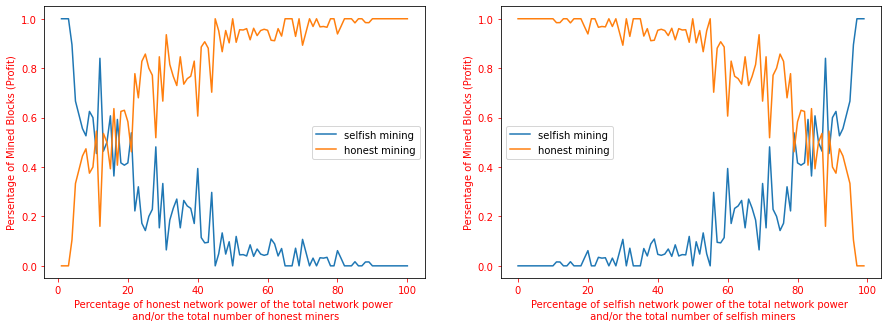

In [11]:
"""
Drawing the results of the previous simulation nr. 4

--- A reminder of Simulation Details ---
In this simulation we aim to determine the effect of an increasing number of selfish miners where all individual honest and selfish miners have equal network and mining power. This simulation has the following setup:

A) Total available mining power of 100

B) starting the total selfish network power at 0

C) starting the total honest network power at 100

D) Total number of miners is 100

E) Each miner will have the same network power as other miners, beacuse we are
1. Increasing the selfish network power from 0 to 99 with selfish_network_power += 1, and at the same time increasing the number of selfish miners from 0 to 99 with num_selfish_miners += 1
2. decreasing the honest network power from 100 to 1 with honest_network_power += 1, and at the same time decreasing the number of honest miners from 100 to 1 with num_honest_miners += 1

F) Mining power is equally divided among to all miners, each miner having a mining power of 1.
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(honest_power, selfish_profits, label = "selfish mining")
axs[0].plot(honest_power, honest_profits, label = "honest mining")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_xlabel('Percentage of honest network power of the total network power \n and/or the total number of honest miners').set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks (Profit)').set_color('red')
axs[0].legend()

axs[1].plot(selfish_power, selfish_profits, label = "selfish mining")
axs[1].plot(selfish_power, honest_profits, label = "honest mining")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_xlabel('Percentage of selfish network power of the total network power \n and/or the total number of selfish miners').set_color('red')
axs[1].set_ylabel('Persentage of Mined Blocks (Profit)').set_color('red')
axs[1].legend()